Nous avons observé que les relevés de débit horaire et de taux d'occupation sont très incomplets dans la rue des Saints-Pères. Ainsi, nous avons décidé d'étudier une de ses rues parallèles, également à sens unique mais dans le sens opposé, l'idée étant que cette rue de substitution joue le même rôle que la rue des Saints-Pères, mais dans le sens contraire. Nous menaons ainsi une étude pour s'assurer de ce choix. 

In [1]:
import pandas as pd
import numpy as np

peres = pd.read_csv('../dataset/sts_peres.csv', sep=";")
bonaparte = pd.read_csv('../dataset/bonaparte.csv', sep=";")

In [2]:
(peres.isnull().sum()/peres.shape[0])*100

Identifiant arc               0.000000
Libelle                       0.000000
Date et heure de comptage     0.000000
Débit horaire                79.289877
Taux d'occupation            79.289877
Etat trafic                   0.000000
Identifiant noeud amont       0.000000
Libelle noeud amont           0.000000
Identifiant noeud aval        0.000000
Libelle noeud aval            0.000000
Etat arc                      0.000000
Date debut dispo data         0.000000
Date fin dispo data           0.000000
geo_point_2d                  0.000000
geo_shape                     0.000000
dtype: float64

In [3]:
(bonaparte.isnull().sum()/bonaparte.shape[0])*100

Identifiant arc                0.000000
Libelle                        0.000000
Date et heure de comptage      0.000000
Débit horaire                  1.910209
Taux d'occupation            100.000000
Etat trafic                    0.000000
Identifiant noeud amont        0.000000
Libelle noeud amont            0.000000
Identifiant noeud aval         0.000000
Libelle noeud aval             0.000000
Etat arc                       0.000000
Date debut dispo data          0.000000
Date fin dispo data            0.000000
geo_point_2d                   0.000000
geo_shape                      0.000000
dtype: float64

On remarque que la rue Bonaparte n'a aucune mesure de Taux d'occupation. l'idée va alors être de se concentrer sur le débit pour ensuite déduire du débit estimé le taux d'occupation à partir des valeurs déjà connues de débit pour la rue des Saints-Pères. Cela est conforté par le fait que les mesures de débit sont quasiment toutes présentes.

In [4]:
bonaparte['Date et heure de comptage'] = pd.to_datetime(
    bonaparte['Date et heure de comptage'],
    errors='coerce',
    utc=True
).dt.tz_convert('Europe/Paris').dt.tz_localize(None)
print(len(bonaparte['Date et heure de comptage'].unique()))

9266


In [5]:
peres['Date et heure de comptage'] = pd.to_datetime(
    peres['Date et heure de comptage'],
    errors='coerce',
    utc=True
).dt.tz_convert('Europe/Paris').dt.tz_localize(None)
print(len(peres['Date et heure de comptage'].unique()))

9266


In [6]:
bonaparte = bonaparte.sort_values('Date et heure de comptage')
peres = peres.sort_values('Date et heure de comptage')

df = pd.merge(bonaparte,peres, on='Date et heure de comptage', how = "inner")

# Nettoyage des deux colonnes (virgules décimales, % éventuel, espaces)
for col in ["Taux d'occupation_x", "Taux d'occupation_y"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ne garder que les lignes où les deux valeurs existent
df_valid = df.dropna(subset=["Débit horaire_x", "Débit horaire_y"])
print('Nombre de lignes utilisées pour calculer la corrélation : ' + str(df_valid.shape[0]))

# Contrôles de validité
n = len(df_valid)
if n < 2:
    raise ValueError("Pas assez de paires valides après nettoyage (n < 2).")

if df_valid["Débit horaire_x"].nunique() == 1 or df_valid["Débit horaire_y"].nunique() == 1:
    raise ValueError("L'une des séries est constante : la corrélation de Pearson est indéfinie.")

# Corrélation de Pearson
r = df_valid["Débit horaire_x"].corr(df_valid["Débit horaire_y"])
print("Corrélation :", r)

Nombre de lignes utilisées pour calculer la corrélation : 1885
Corrélation : 0.8932025415739622


Le coefficient de corrélation est donc très convaincant. Nous allons utiliser cette donner pour estimer le débit dans la rue des Saints-Pères. 

<h2>Traitement du fichier sts_peres.csv</h2>

Nous allons tout d'abord garder en mémoire les valeurs déja connues, et également nous intéresser à la relation entre débit et taux d'occupation dans la rue des Saints-Pères. 

In [7]:
peres_tx_debit = peres.dropna(subset=["Débit horaire", "Taux d\'occupation"])
print(peres_tx_debit.shape)

(1919, 15)


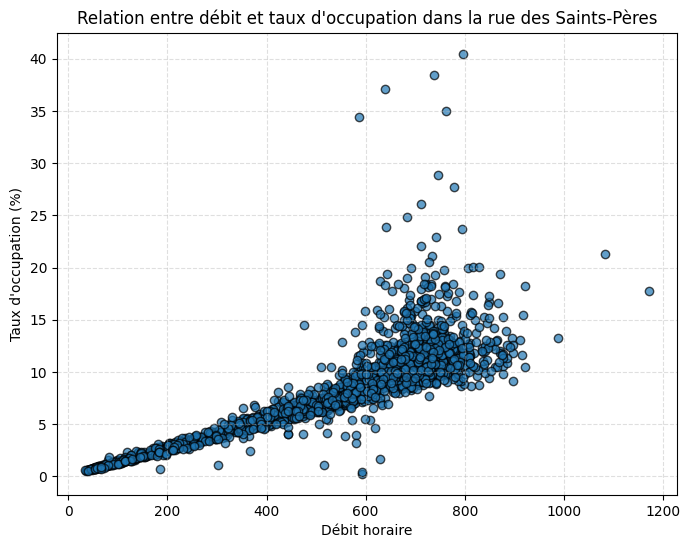

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(peres_tx_debit['Débit horaire'],peres_tx_debit['Taux d\'occupation'], alpha=0.7, edgecolors='k')
plt.xlabel("Débit horaire")
plt.ylabel("Taux d'occupation (%)")
plt.title("Relation entre débit et taux d'occupation dans la rue des Saints-Pères")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

st_peres = pd.read_csv('../dataset/sts_peres.csv', sep=";")

st_peres['Date et heure de comptage'] = pd.to_datetime(st_peres['Date et heure de comptage'], 
errors='coerce', utc=True).dt.tz_convert('Europe/Paris').dt.tz_localize(None)

st_peres['jour_semaine'] = st_peres['Date et heure de comptage'].dt.day_name(locale='fr_FR') 
st_peres['num_jour_mois'] = st_peres['Date et heure de comptage'].dt.day
st_peres['heure'] = st_peres['Date et heure de comptage'].dt.hour
st_peres['mois'] = st_peres['Date et heure de comptage'].dt.month
st_peres['num_jour_mois'] = st_peres['Date et heure de comptage'].dt.day

meteo = pd.read_csv('../dataset/meteo.csv',sep=";")
meteo['datetime'] = pd.to_datetime(meteo['datetime'])

df_merge = pd.merge(st_peres,meteo,left_on='Date et heure de comptage', right_on='datetime', how='left')

In [10]:
import numpy as np

def add_is_holiday_by_date(
    df_main: pd.DataFrame,
    df_holidays: pd.DataFrame,
    date_col_main: str = "Date et heure de comptage",
    start_col: str = "Date de début",
    end_col: str = "Date de fin",
    tz: str = "Europe/Paris",
    out_col: str = "is_holiday",
) -> pd.DataFrame:
    """
    Ajoute une colonne binaire `out_col` (0/1) indiquant si la DATE (indépendamment de l'heure)
    appartient à une période de vacances/jour férié (bornes inclusives).
    """
    df = df_main.copy()
    hol = df_holidays.copy()

    for c in (start_col, end_col):
        hol[c] = pd.to_datetime(hol[c], errors="coerce", utc=True)\
                    .dt.tz_convert(tz)\
                    .dt.tz_localize(None)

    all_dates: list[pd.DatetimeIndex] = []
    for _, row in hol.dropna(subset=[start_col, end_col]).iterrows():
        d0 = row[start_col].normalize()  
        d1 = row[end_col].normalize()   
        rng = pd.date_range(d0, d1, freq="D") 
        all_dates.append(rng)

    if all_dates:
        holiday_dates = pd.DatetimeIndex(
            np.unique(np.concatenate([idx.values for idx in all_dates]))
        )
    else:
        holiday_dates = pd.DatetimeIndex([])

    df[date_col_main] = pd.to_datetime(df[date_col_main], errors="coerce")
    day_col = df[date_col_main].dt.normalize()

    df[out_col] = day_col.isin(holiday_dates).astype("int8")

    return df


holidays = pd.read_csv('../dataset/vacances.csv', sep=";")

df_final = add_is_holiday_by_date(df_merge,holidays)

In [11]:
def add_ferie_flags_by_date(
    df_main: pd.DataFrame,
    df_feries: pd.DataFrame,
    date_col_main: str = "Date et heure de comptage",
    ferie_label_col: str = "Description",      
    ferie_date_col: str = "Date de début", 
    tz: str = "Europe/Paris"
) -> pd.DataFrame:
    """
    Ajoute deux colonnes au df principal :
      - is_ferie (int8) : 1 si la date est un jour férié
      - is_avant_ferie (int8) : 1 si la date est la veille d'un jour férié
    """
    fer = df_feries.copy()
    fer.columns = fer.columns.str.strip()

    fer_dates = pd.to_datetime(fer[ferie_date_col].astype(str).str.strip(),
                               errors="coerce", dayfirst=True)

    if pd.api.types.is_datetime64tz_dtype(fer_dates):
        fer_local = fer_dates.dt.tz_convert(tz).dt.tz_localize(None)
    else:
        fer_local = fer_dates.dt.tz_localize(
            tz, ambiguous="infer", nonexistent="shift_forward"
        ).dt.tz_localize(None)

    fer_days = fer_local.dt.normalize().dropna()

    ferie_set = pd.DatetimeIndex(sorted(fer_days.unique()))

    df = df_main.copy()
    df[date_col_main] = pd.to_datetime(df[date_col_main], errors="coerce")

    if pd.api.types.is_datetime64tz_dtype(df[date_col_main]):
        day_local = df[date_col_main].dt.tz_convert(tz).dt.tz_localize(None).dt.normalize()
    else:
        day_local = df[date_col_main].dt.tz_localize(None).dt.normalize()

    df["is_ferie"] = day_local.isin(ferie_set).astype("int8")
    df["is_avant_ferie"] = day_local.isin(ferie_set - pd.Timedelta(days=1)).astype("int8")

    return df

ferie = pd.read_csv('../dataset/ferie.csv', sep=";")
df_final = add_ferie_flags_by_date(df_final,ferie)

df_final = df_final.sort_values('Date et heure de comptage')


/var/folders/qc/5qn44xzs143g6s6sy04v51qm0000gn/T/ipykernel_18290/464367248.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(fer_dates):
/var/folders/qc/5qn44xzs143g6s6sy04v51qm0000gn/T/ipykernel_18290/464367248.py:34: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df[date_col_main]):


In [12]:
df_final['duree prec (en min)'] = df_final['duree prec (en min)'].fillna(0)
df_final.isnull().sum()

Identifiant arc                 0
Libelle                         0
Date et heure de comptage       0
Débit horaire                7347
Taux d'occupation            7347
Etat trafic                     0
Identifiant noeud amont         0
Libelle noeud amont             0
Identifiant noeud aval          0
Libelle noeud aval              0
Etat arc                        0
Date debut dispo data           0
Date fin dispo data             0
geo_point_2d                    0
geo_shape                       0
jour_semaine                    0
num_jour_mois                   0
heure                           0
mois                            0
Unnamed: 0                      0
NOM_USUEL                       0
precipitations heure            0
duree prec (en min)             0
force moyenne vent (m/s)        0
Température                     8
datetime                        0
is_holiday                      0
is_ferie                        0
is_avant_ferie                  0
dtype: int64

In [37]:
import numpy as np  
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


features = [
    'Température', 'precipitations heure', 'is_holiday', 'heure',
    'force moyenne vent (m/s)', 'mois', 'jour_semaine', 'is_ferie', 'is_avant_ferie'
]
target = 'Débit horaire'

mask_known = df_final[target].notna()
mask_missing = df_final[target].isna()

X_known = df_final.loc[mask_known, features].copy()
y_known = df_final.loc[mask_known, target].astype(float)

X_missing = df_final.loc[mask_missing, features].copy()

numeric_features = [
    'Température', 'precipitations heure', 'is_holiday', 'heure',
    'force moyenne vent (m/s)', 'mois', 'is_ferie', 'is_avant_ferie'
]
categorical_features = ['jour_semaine']  

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),
    ],
    remainder='drop'
)

model = HistGradientBoostingRegressor(
    loss='absolute_error',   
    max_depth=6,
    max_iter=200,
    random_state=42
)

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X_known, y_known, test_size=0.2, shuffle=False
)

W_FERIE = 3.0
W_AVANT = 1.5

w_train = np.ones(len(X_train), dtype=float)

is_ferie_train = X_train['is_ferie'].fillna(0).astype(int)
is_avant_train = X_train['is_avant_ferie'].fillna(0).astype(int)

w_train[is_ferie_train == 1] = W_FERIE
w_train[is_avant_train == 1] = np.maximum(w_train[is_avant_train == 1], W_AVANT)

w_train *= (len(w_train) / w_train.sum())

pipe.fit(X_train, y_train, model__sample_weight=w_train)

y_pred = pipe.predict(X_test)
mask_ferie = X_test['is_ferie'].fillna(0).to_numpy().astype(int) == 1
y_pred[mask_ferie] *= 0.8


print(f"R² sur données réelles : {r2_score(y_test, y_pred):.3f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Diagnostics par sous-régimes (fériés vs non fériés) sur le jeu de test
is_ferie_test = X_test['is_ferie'].fillna(0).astype(int) == 1
is_non_ferie_test = ~is_ferie_test

if is_ferie_test.any():
    mae_feries = mean_absolute_error(y_test[is_ferie_test], y_pred[is_ferie_test])
    print(f"MAE (jours fériés) : {mae_feries:.2f} (n={is_ferie_test.sum()})")
else:
    print("Aucun jour férié dans le jeu de test.")

if is_non_ferie_test.any():
    mae_non_feries = mean_absolute_error(y_test[is_non_ferie_test], y_pred[is_non_ferie_test])
    print(f"MAE (hors fériés) : {mae_non_feries:.2f} (n={(is_non_ferie_test).sum()})")

# ------------------------------------------------
# 6) Prédire les valeurs manquantes
# ------------------------------------------------
df_final.loc[mask_missing, 'Débit_prédit'] = pipe.predict(X_missing)


R² sur données réelles : 0.880
MAE : 55.83
RMSE : 77.56
MAE (jours fériés) : 62.63 (n=24)
MAE (hors fériés) : 55.37 (n=360)


In [38]:
import plotly.graph_objects as go

time_index = df_final.loc[X_test.index, 'Date et heure de comptage']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time_index,
    y=y_pred,
    mode='lines',
    name='Débit prédit'
))
fig.add_trace(go.Scatter(
    x=time_index,
    y=y_test,
    mode='lines',
    name='Débit réel'
))

fig.update_layout(
    title="Comparaison des débits (réel vs prédit)",
    xaxis_title="Date et heure",
    yaxis_title="Débit horaire (véh/h)",
    hovermode='x unified'
)

fig.show()

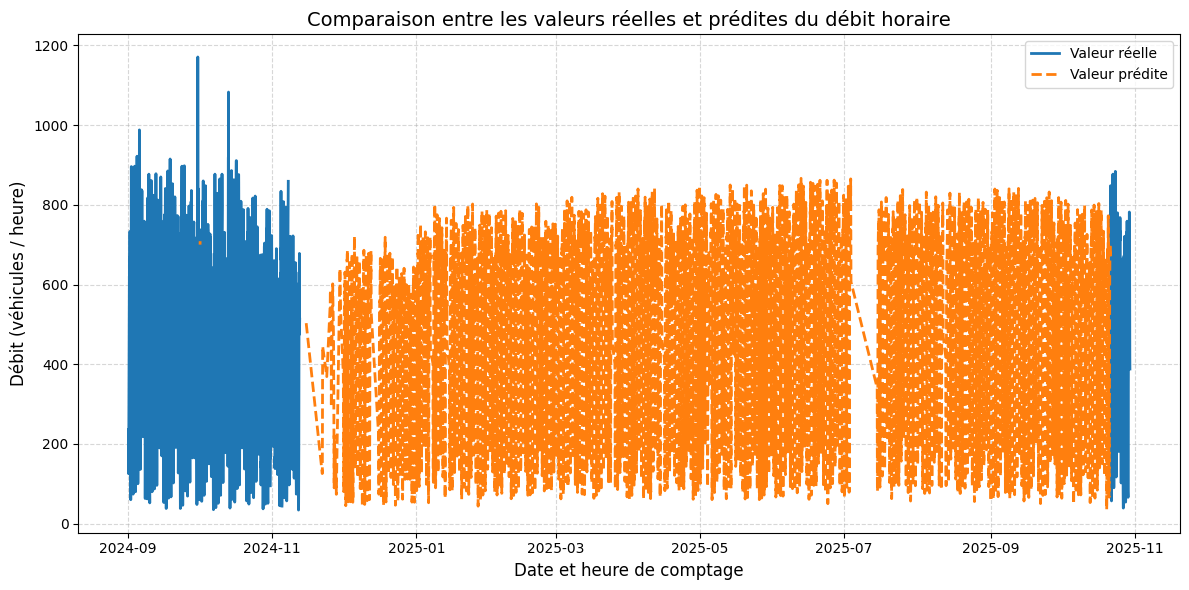

In [39]:
import matplotlib.pyplot as plt

# Supposons :
# df_final contient :
#   - 'Date et heure de comptage'
#   - 'Débit horaire' (valeur réelle)
#   - 'Débit_prédit' (valeur estimée par votre modèle)

plt.figure(figsize=(12,6))
plt.plot(df_final['Date et heure de comptage'], df_final['Débit horaire'], 
         label="Valeur réelle", color='tab:blue', linewidth=2)
plt.plot(df_final['Date et heure de comptage'], df_final['Débit_prédit'], 
         label="Valeur prédite", color='tab:orange', linestyle='--', linewidth=2)

plt.title("Comparaison entre les valeurs réelles et prédites du débit horaire", fontsize=14)
plt.xlabel("Date et heure de comptage", fontsize=12)
plt.ylabel("Débit (véhicules / heure)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [40]:
# Prédiction sur toutes les lignes du DataFrame
df_final['Débit_prédit_total'] = pipe.predict(df_final[features])


In [41]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

mask_real = df_final['Débit horaire'].notna()

r2 = r2_score(df_final.loc[mask_real, 'Débit horaire'],
              df_final.loc[mask_real, 'Débit_prédit_total'])
mae = mean_absolute_error(df_final.loc[mask_real, 'Débit horaire'],
                          df_final.loc[mask_real, 'Débit_prédit_total'])
rmse = np.sqrt(mean_squared_error(df_final.loc[mask_real, 'Débit horaire'],
                                  df_final.loc[mask_real, 'Débit_prédit_total']))

print(f"Performance sur les données réelles connues :")
print(f"R² = {r2:.3f} | MAE = {mae:.2f} | RMSE = {rmse:.2f}")


Performance sur les données réelles connues :
R² = 0.940 | MAE = 35.26 | RMSE = 57.56


In [43]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_final['Date et heure de comptage'],
    y=df_final['Débit horaire'],
    mode='lines',
    name='Débit réel'
))
fig.add_trace(go.Scatter(
    x=df_final['Date et heure de comptage'],
    y=df_final['Débit_prédit_total'],
    mode='lines',
    name='Débit prédit'
))

fig.update_layout(
    title="Comparaison des débits (réel vs prédit)",
    xaxis_title="Date et heure",
    yaxis_title="Débit horaire (véh/h)",
    hovermode='x unified'
)

fig.show()


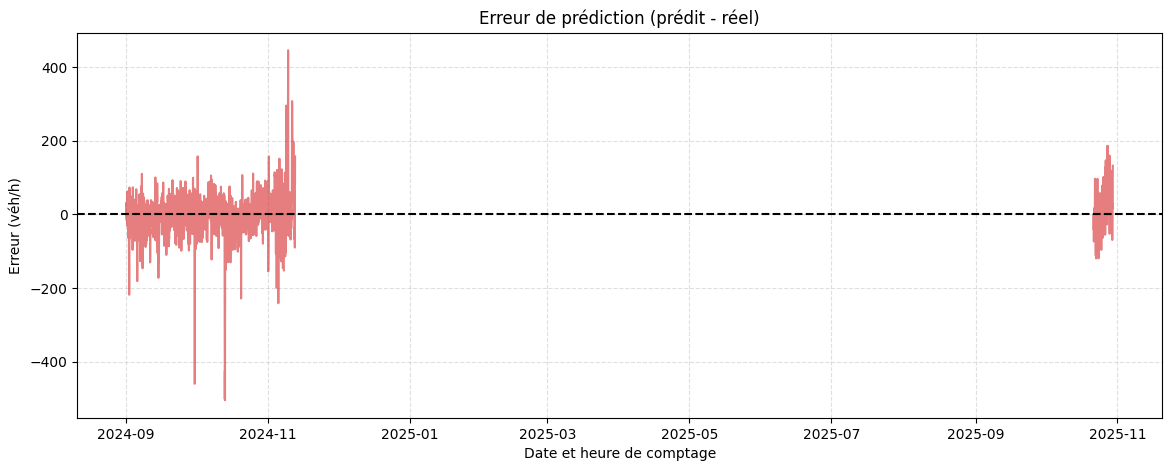

In [44]:
df_final['erreur'] = df_final['Débit_prédit_total'] - df_final['Débit horaire']

plt.figure(figsize=(14,5))
plt.plot(df_final['Date et heure de comptage'], df_final['erreur'],
         color='tab:red', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Erreur de prédiction (prédit - réel)")
plt.xlabel("Date et heure de comptage")
plt.ylabel("Erreur (véh/h)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()
